In [1]:
%load_ext autoreload

In [2]:
from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

from utils.min_norm_solvers_numpy import MinNormSolver, gradient_normalizers

/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
%autoreload 2

In [5]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [6]:
data_dir = os.path.join('data', '1.1')

# Environment Setup

In [7]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

# tile_map = [
#         "2FFFUFFF1",
#         "FFFU3UFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUUSUUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_map = [
        "2FFFUFFF1",
        "FFFUUUFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUU3UUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':8.0,
              'S':0.0,
              'U':0.0}


# Enables "texturizing" the environment such that certain areas
# will have greater reward despite being the same tile types
tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.001,0.0,0.0,0.999)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

true_tps = np.array([[[0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 0.999]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.0, 0.999]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.95

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [8]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
num_actions = mdp.num_actions
num_states = mdp.num_states

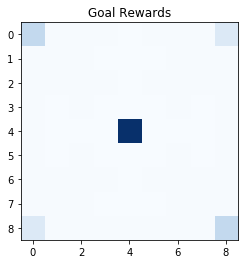

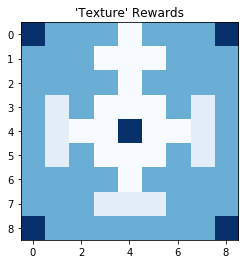

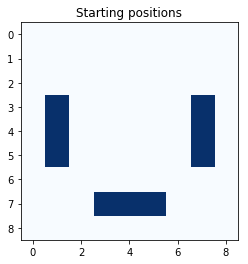

In [9]:
plt.imshow(reward_map, cmap="Blues")
plt.title("Goal Rewards")
plt.show()
plt.imshow(texture_map, cmap="Blues")
plt.title("'Texture' Rewards")
plt.show()

binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")
plt.title("Starting positions")
plt.show()

# Demo visualization tools

In [10]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning for Demonstrations

In [11]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [12]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    #TODO removed reliance on global state
    Q = np.zeros((num_states, num_actions)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        # Need this to be treated more like a hard max
        V = logsumexp(prevQ * 10000, axis=1) / 10000
        V_broad = V.reshape((1, 1, num_states))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            print(Q)
            print(gamma * np.sum(T * V_broad, axis=2))
            print(V)
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [13]:
def tabsoftq_learn_Qs(mdp):
    R = np.repeat(mdp.rewards[np.newaxis].T, 5, axis=1)
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [14]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [15]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  # Remove the CWD from sys.path while we load stuff.


[[ 40.54471131  39.3663655   39.3663655   40.54471131  42.        ]
 [ 39.07270766  35.41521307  34.8190973   36.40304558  37.16907227]
 [ 36.40314427  32.90307833  30.20220223  33.75740667  34.63298705]
 [ 30.91357339   4.05165815   3.68526051  28.65192842  29.41789472]
 [  0.57641625   0.54706149   0.5758945    0.57392227   0.54759595]
 [  3.7437348    3.96301499  30.36436803  29.056446    28.89614962]
 [ 29.77573859  32.07186961  35.60356577  34.21409817  33.87338748]
 [ 34.21766804  34.46794579  38.03256169  36.98679704  36.1809336 ]
 [ 37.60784024  37.60784024  40.62309336  40.62309336  39.69200454]
 [ 36.40304558  34.8190973   35.41521307  39.07270766  37.16907227]
 [ 36.73271275  33.24183656  33.24183656  36.73271275  34.94614296]
 [ 34.47944951  28.03458079   7.051135    31.26707892  32.80547704]
 [  0.64289454   0.63350319   0.61015221   0.63950696   0.61074982]
 [  0.01373914   0.01356404   0.01372329   0.01367599   0.01314153]
 [  0.59431406   0.61706539   0.62620612   0.623

/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


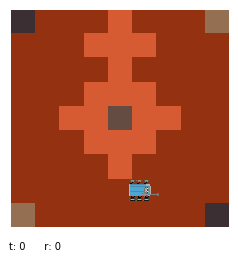

[26.73968225 31.46912266 32.03024937 26.85735377 30.4387369 ]
2
[0.00282309 0.31966437 0.56025853 0.00317562 0.11407839]
(5, 7) b'S'
(6, 7) b'F'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


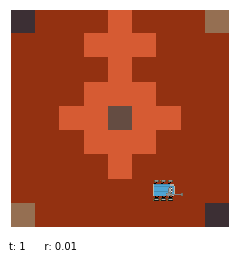

[30.90552702 34.24887786 34.47945207 31.01639814 32.80547946]
2
[0.01374137 0.38907102 0.48996606 0.01535256 0.09186899]
(6, 7) b'F'
(7, 7) b'F'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


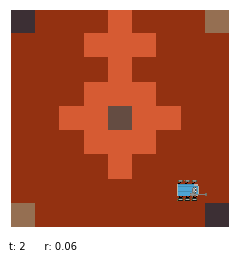

[33.24183875 36.73271301 36.73271301 33.24183875 34.94614321]
2
[0.01367488 0.4487359  0.4487359  0.01367488 0.07517846]
(7, 7) b'F'
(8, 7) b'F'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


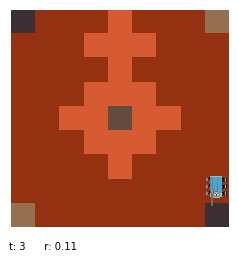

[35.4152133  39.07270768 36.40304561 34.81909753 37.1690723 ]
1
[0.02050134 0.79471584 0.05505444 0.01129516 0.11843322]
(8, 7) b'F'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


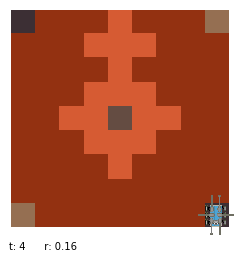

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


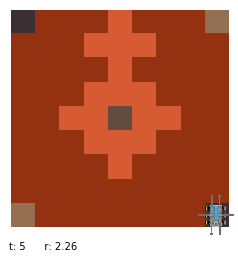

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


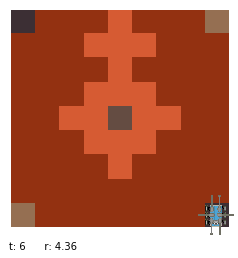

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


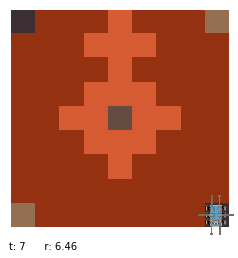

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


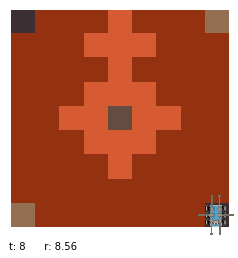

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


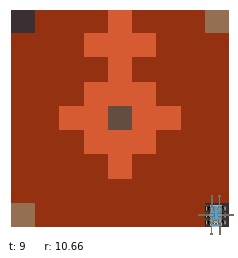

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


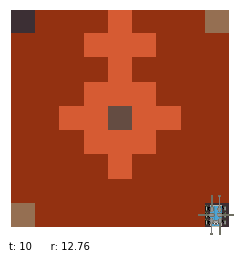

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


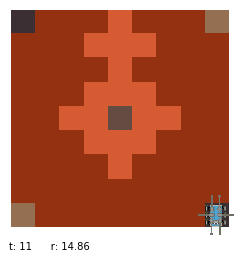

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


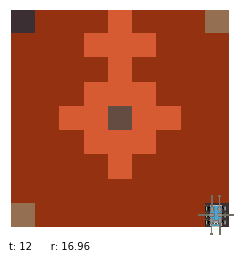

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


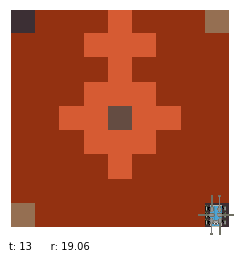

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


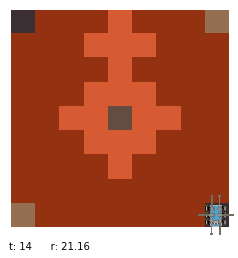

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


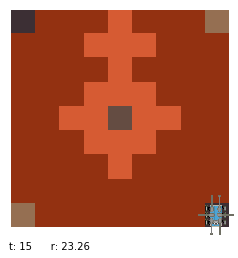

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


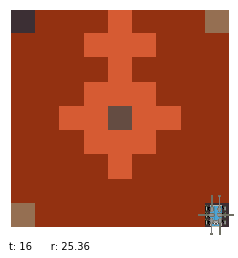

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


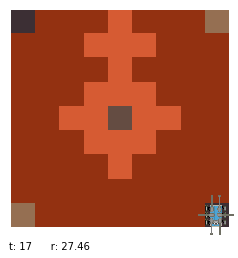

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


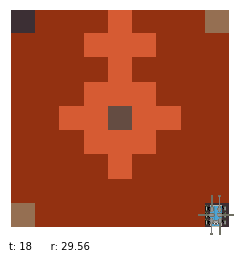

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


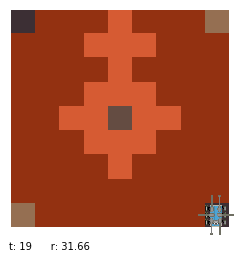

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


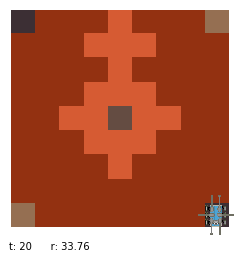

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


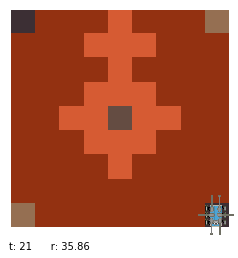

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


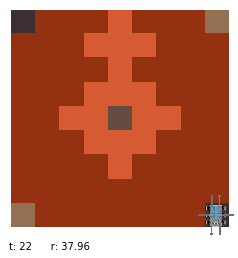

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


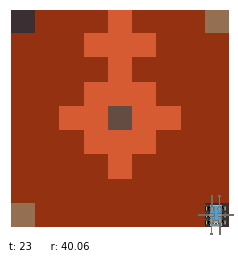

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


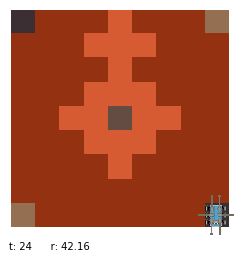

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


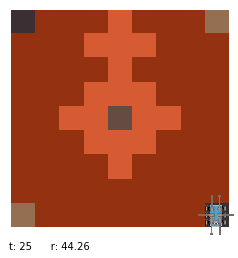

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


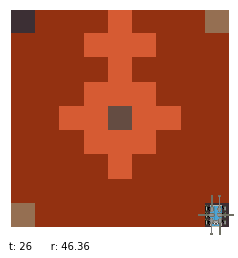

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


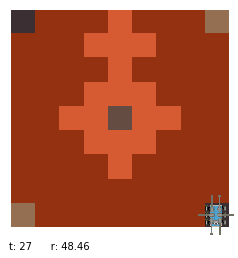

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


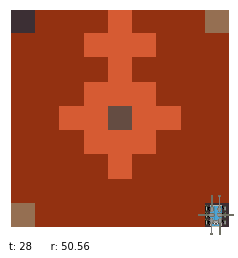

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


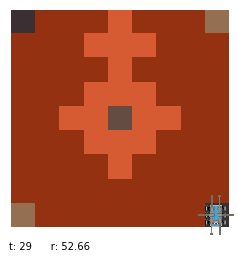

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


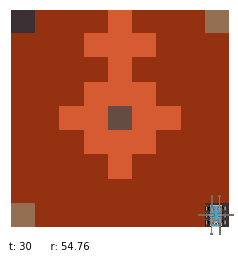

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


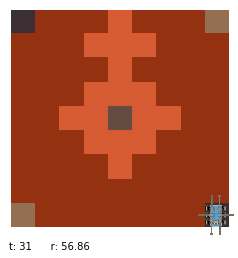

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


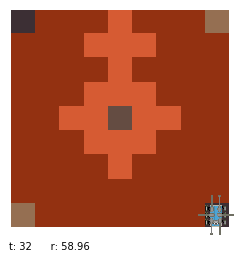

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


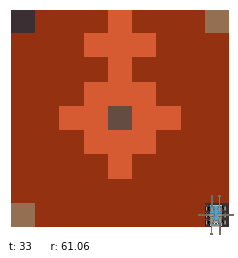

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


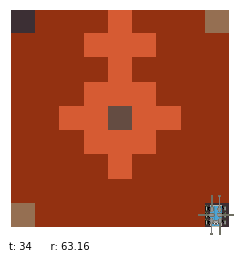

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


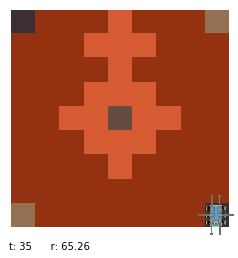

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


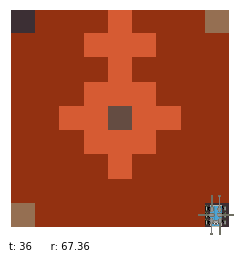

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


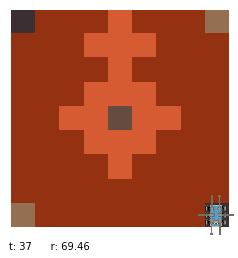

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


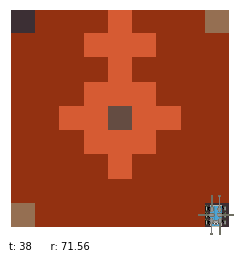

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


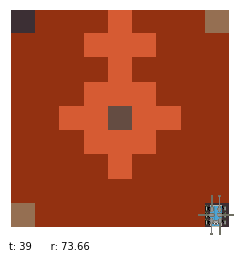

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


In [16]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q*50),Qs=Q)


# Model Set Up

In [17]:
train_demo_example_idxes = None
val_demo_example_idxes = None

gamma = 0.99
iterations = 100000
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
batch_size = 512
sq_td_err_penalty = 1
trans_penalty = 1
t_err_penalty = 1e0
q_err_penalty = 1e0


q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 256
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [18]:
n_obs_feats = mdp.nrow + mdp.ncol
n_act_dim = 5

gridify_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])

def featurize_states(states):
    grid_points = gridify_states(states)
    row_one_hots, col_one_hots = np.eye(mdp.nrow), np.eye(mdp.ncol)
    return np.array([np.concatenate((row_one_hots[gp[0]], col_one_hots[gp[1]])) for gp in grid_points])
    

featurize_acts = lambda a: a
n_dirs = 5

In [19]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [20]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    #TODO remove reliance on global state
    s = np.arange(mdp.num_states)
    a = np.arange(mdp.num_actions) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    grid_states = gridify_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(states)
    sps = sprimes.shape
    feat_next_states = featurize_states(sprimes.reshape((sps[0]*sps[1]))).reshape((sps[0],sps[1], n_obs_feats))

    return feat_states, acts_array, rewards, feat_next_states, tiles

In [21]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######

# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [22]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [23]:
sess = tf.Session()

In [24]:
# Demo placeholders are for the action-likelihood and transition-likelihood portions of the loss
# Constraint placeholders are for the bellman-residual penalty

demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [25]:
# Boltz-beta determines the "rationality" of the agent being modeled. 
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation) * boltz_beta

demo_v_t = tf.reduce_logsumexp(demo_q_t, axis=1)

In [26]:
action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) - demo_v_t

neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [27]:
# Encoded the potential to use "sas" transitions, which are simply state, action, state observations,
# and "adt" transitions -- post-processed to determine (a)ction taken, (d)irection moved, and starting (t)ile-type
# Learning an "adt" transition model should be much easier

sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_t_ph, demo_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [28]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_t_ph, constraint_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [29]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [30]:
# Q-values used to calculate 'V' in the bellman-residual
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))


constraint_v_tp1 = tf.reduce_logsumexp(constraint_q_tp1, axis=2) #(tf.reduce_logsumexp(constraint_q_tp1 * boltz_beta, axis=2) - np.log(n_act_dim)) / boltz_beta

In [31]:
# sas bellman residual penalty error
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
sas_V = tf.multiply(constraint_v_tp1, constraint_sas_pred_probs)
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)


# adt bellman residual penalty error
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
adt_V = tf.multiply(constraint_v_tp1, constraint_adt_pred_probs)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

In [32]:
# sas and adt bellman residual penalty error with a stop gradient on transitions to prevent the bellman update from
# 'hacking' the transition function to overly explain the demonstrations. This happens a lot early on before the
# Q-values have obtained much meaning

sas_V_sgt = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
sas_target_sgt = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V_sgt, axis=1)
sas_td_err_sgt = tf.reduce_mean((constraint_q_t - sas_target_sgt)**2)

adt_V_sgt = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
adt_target_sgt = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sgt, axis=1)
adt_td_err_sgt = tf.reduce_mean((constraint_q_t - adt_target_sgt)**2)

# test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
# test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
# test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
# indiv_errs = test_constraint_q_t_ph - test_adt_target
# test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)


# sas and adt bellman residual penalty error with a stop gradient on q-fn to allow the bellman residual loss to update
# differences in learned q-vals w.r.t. the dynamics model

adt_V_sgq = tf.multiply(tf.stop_gradient(constraint_v_tp1), constraint_adt_pred_probs)
adt_target_sgq = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sgq, axis=1)
adt_td_err_sgq = tf.reduce_mean((tf.stop_gradient(constraint_q_t) - adt_target_sgq)**2)

# HACK TO GET NON-NONE GRADIENTS
adt_td_err_sgt += 1e-20 * adt_td_err_sgq
adt_td_err_sgq += 1e-20 * adt_td_err_sgt

In [33]:
# Total loss function for the sas formulation
sas_loss = neg_avg_act_log_likelihood + trans_penalty * neg_avg_sas_log_likelihood + sq_td_err_penalty * sas_td_err

# Total loss function for the adt formulation
adt_loss = neg_avg_act_log_likelihood + trans_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err

# Loss function for the adt formulation that only optimizes over the q-value approximation 
adt_q_loss = neg_avg_act_log_likelihood + q_err_penalty * adt_td_err_sgt

# Loss function for the adt formulation that only optimizes over the dynamics model
adt_t_loss = neg_avg_adt_log_likelihood + t_err_penalty * adt_td_err_sgq

# Loss function for the adt formulation that learns unseen dynamics
adt_learn_loss = neg_avg_act_log_likelihood + t_err_penalty * adt_td_err_sgq

# Loss function for the adt formulation that regularizes over observed and learned quantities
adt_regularize_loss = neg_avg_adt_log_likelihood + q_err_penalty * adt_td_err_sgt

# Total loss function for the adt formulation with a stop-gradient on the transition function for the bellman residual
adt_brsgt_loss = neg_avg_act_log_likelihood + trans_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err_sgt

# HACK TO GET NON-NONE GRADIENTS
nall_loss = neg_avg_act_log_likelihood + 1e-20 * neg_avg_adt_log_likelihood
ntll_loss = neg_avg_adt_log_likelihood + 1e-20 * neg_avg_act_log_likelihood

In [34]:
sas_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(sas_loss)

adt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_loss)

adt_brsgt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_brsgt_loss)

adt_q_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_q_loss)

adt_t_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_t_loss)

adt_learn_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_learn_loss)

adt_regularize_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_regularize_loss)

adt_trans_only_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_adt_log_likelihood)

adt_q_br_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_td_err_sgt)

q_nll_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_act_log_likelihood)

In [35]:
# Uncertainty weighted loss function motivated by https://arxiv.org/pdf/1705.07115.pdf

sigma_a, sigma_t, sigma_br = tf.Variable(0.0), tf.Variable(0.0), tf.Variable(0.0)

# Simple sum is sufficient so long as all losses use means
sigma_log_losses = sigma_a + sigma_t # + sigma_br

weighted_na_act_ll = tf.exp(-sigma_a) * neg_avg_act_log_likelihood

weighted_na_adt_ll = tf.exp(-sigma_t) * neg_avg_adt_log_likelihood

weighted_na_br = (adt_td_err * sq_td_err_penalty + adt_td_err_sgt * 3 * sq_td_err_penalty) / 4 #tf.exp(-sigma_br) * 

adt_uncertainty_loss = weighted_na_act_ll + weighted_na_adt_ll + weighted_na_br + sigma_log_losses

adt_un_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_uncertainty_loss)

In [36]:
# Add in ability to train the q-fn approximator on the true values to test model capacity
true_qs_ph = tf.placeholder(tf.float32, [None], name="tq")
true_q_errs = constraint_q_t - true_qs_ph
true_q_err = tf.reduce_sum((true_q_errs)**2)
true_q_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(true_q_err)

In [53]:
def compute_batch_loss(demo_batch, constraints, step=False, update="adt", true_qs=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    # Naive case of only optimizing over observed transitions -- useful to initialize the dynamics model
    if update == "trans": 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        d = {'loss':trans_likelihood_eval}
    
    # Optimization over the full adt loss function
    if update == "adt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # Optimization over the adt uncertainty-weighted loss function
    if update == "adt_un":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval, sig_a, sig_t, sig_br] = sess.run(
            [adt_uncertainty_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood,
                 sigma_a, sigma_t, sigma_br], feed_dict=feed_dict)
        update_op = adt_un_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval,
            'sigmas': (sig_a, sig_t, sig_br)}
        
    # Optimizing only the q-fn over the bellman residual, equivalent to soft Q-learning
    if update == "adt_br":
        [loss_eval] = sess.run([adt_td_err_sgt], feed_dict=feed_dict)
        update_op = adt_q_br_update_op
        d = {'loss': loss_eval}
    
    # Optimization over the full adt loss function with a stop gradient on the dynamics model for the bellman residual
    # Useful in getting the q-fn to match both the observed dynamics and the observed actions taken
    if update == "adt_brsgt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err_sgt, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_brsgt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimization over the action likelihood and br with a stop gradient on the dynamics model for the br
    if update == "adt_q":
        [loss_eval, act_likelihood_eval, td_err_eval] = sess.run(
            [adt_q_loss, neg_avg_act_log_likelihood, adt_td_err_sgt], feed_dict=feed_dict)
        update_op = adt_q_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval}
        
    # Optimization over the action likelihood and br with a stop gradient on the q-fn for the br
    if update == "adt_learn":
        [loss_eval,  trans_likelihood_eval, td_err_eval, act_likelihood_eval] = sess.run(
            [adt_learn_loss, neg_avg_adt_log_likelihood, adt_td_err_sgq, neg_avg_act_log_likelihood], feed_dict=feed_dict)
        update_op = adt_learn_update_op
        d = {'loss': loss_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval,
            'nall': act_likelihood_eval}
        
    # Optimization over the transition likelihood and br with a stop gradient on the dynamics for the br
    if update == "adt_regularize":
        [loss_eval, trans_likelihood_eval, td_err_eval] = sess.run(
            [adt_regularize_loss, neg_avg_adt_log_likelihood, adt_td_err_sgt], feed_dict=feed_dict)
        update_op = adt_regularize_update_op
        d = {'loss': loss_eval,
            'ntll': trans_likelihood_eval,
            'tde': td_err_eval}
        
    # Optimization over the transition likelihood and br with a stop gradient on the q-fn for the br
    if update == "adt_t":
        [loss_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_t_loss, adt_td_err_sgq, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_t_update_op
        d = {'loss': loss_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimization over the full sas loss function
    if update == "sas":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # For debugging and testing model capacity
    if update == "true_qs":
        feed_dict[true_qs_ph] = true_qs
        [loss_eval] = sess.run([true_q_err], feed_dict=feed_dict)
        update_op = true_q_update_op
        d = {'loss': loss_eval}
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)

    return d

In [38]:
def update_switcher(update, update_progression, losses, slope_threshold=1e-4, horizon=100):
    
    if len(losses) <= 3:
        switch = False
    else:
        if len(losses) < horizon:
            horizon = len(losses)
        slope = np.polyfit(np.arange(horizon), losses[-horizon:], 1)[0]
        switch = -slope < slope_threshold
        
        print(-slope, switch)
        
    if switch:
        if update not in update_progression:
            update = update_progression[0]
        else:
            update = update_progression[(update_progression.index(update) + 1) % len(update_progression)]
        
    return update

# IDL Experiments

## Demo setup

In [39]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [40]:
def clean_demos(sas_obs, max_noops=15):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > max_noops:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [41]:
exQs = tabsoftq_learn_Qs(mdp)
# The rationality constant used to generate demos could certainly vary from the one used in the model.....
temp_boltz_beta = 50
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * temp_boltz_beta), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  # Remove the CWD from sys.path while we load stuff.


[[208.44793162 207.18127902 207.18127902 208.44793162 210.        ]
 [206.99287621 202.96944566 202.29977102 204.1002877  204.97294744]
 [204.07436214 198.44322909 185.17373676 199.58882701 202.08361852]
 [183.12845022  36.32702745  34.95093068 179.15448334 181.34716572]
 [ 16.97620454  16.79653099  16.97556524  16.98153444  16.8117191 ]
 [ 35.01525282  36.16339701 182.48269324 179.65517111 180.70786631]
 [184.64716479 197.4379815  203.17779759 200.12479717 201.19601961]
 [201.59176201 201.87644087 205.87995687 204.75358624 203.87115731]
 [205.32904157 205.32904157 208.59211573 208.59211573 207.60626319]
 [204.10032334 202.30005617 202.9694813  206.99287621 204.97294744]
 [204.45205845 200.28494297 200.28491827 204.45205492 202.45760476]
 [201.73133557 178.50494151  54.19774545 183.716717   199.76402222]
 [ 18.17234051  18.13088664  17.9742501   18.15392365  17.99061711]
 [  1.63997683   1.63624259   1.63988324   1.63879793   1.62360982]
 [ 17.88075551  18.03661872  18.077807    18.059

In [42]:
# Ensure bad areas have not been visited in exes (this is unique to this experiment)
demos = []
while len(demos) < n_demos:
    new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
    more_sas, more_adt = list(zip(*new_demo))
    if len(set([adt[2] for adt in more_adt])) == 1:
        demos += [new_demo]
        
sas_obs, adt_obs = vectorize_rollouts(demos)

In [43]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [57]:
# True q-vals for debugging and comparison purposes
Qs = tabsoftq_learn_Qs(mdp)
sa = np.transpose([np.tile(np.arange(mdp.num_states), mdp.num_actions), np.repeat(np.arange(mdp.num_actions), mdp.num_states)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

# Preprocessing for training update visualizations
tts = np.arange(2)
acts = np.arange(num_actions) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]
states = featurize_states(np.arange(num_states))

# Optional preloading of q-fn or dynamics models
# q_net_path = os.path.join(data_dir, 'true_q_16384.tf')
# save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, q_scope, q_net_path)

#invadt_path = os.path.join(data_dir, 'adt_fw_t.tf')
#load_tf_vars(sess, invadt_scope, invadt_path)

/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  # Remove the CWD from sys.path while we load stuff.


[[208.44793162 207.18127902 207.18127902 208.44793162 210.        ]
 [206.99287621 202.96944566 202.29977102 204.1002877  204.97294744]
 [204.07436214 198.44322909 185.17373676 199.58882701 202.08361852]
 [183.12845022  36.32702745  34.95093068 179.15448334 181.34716572]
 [ 16.97620454  16.79653099  16.97556524  16.98153444  16.8117191 ]
 [ 35.01525282  36.16339701 182.48269324 179.65517111 180.70786631]
 [184.64716479 197.4379815  203.17779759 200.12479717 201.19601961]
 [201.59176201 201.87644087 205.87995687 204.75358624 203.87115731]
 [205.32904157 205.32904157 208.59211573 208.59211573 207.60626319]
 [204.10032334 202.30005617 202.9694813  206.99287621 204.97294744]
 [204.45205845 200.28494297 200.28491827 204.45205492 202.45760476]
 [201.73133557 178.50494151  54.19774545 183.716717   199.76402222]
 [ 18.17234051  18.13088664  17.9742501   18.15392365  17.99061711]
 [  1.63997683   1.63624259   1.63988324   1.63879793   1.62360982]
 [ 17.88075551  18.03661872  18.077807    18.059

## IDL Training

In [58]:
n_training_iters = 1000000

In [59]:
tf.global_variables_initializer().run(session=sess)

In [60]:
train_log_base = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
  'sigmas_evals': []
}

mode_logs = {}

val_log = None

In [61]:
# The best order of optimization seems to be "trans" -> "adt_br" -> "adt_brsgt" -> "adt" [->"adt-br"->"adt"]

# update = "trans"
# update = "adt_q"
# update = "adt_t"

# update = "adt_learn"
# update = "trans"
# update = "adt_br"
# update = "adt_regularize"

# update_progression = ["adt_regularize", "adt_learn"]

update_progression = ["true_qs"]

for up in update_progression:
    mode_logs[up] = copy(train_log_base)
    
update = "true_qs"

mode_logs[update] = copy(train_log_base)


full_train_logs = mode_logs[update]


# update = "adt_br"
# update = "adt_brsgt"
# update = "adt"
# update = "adt_un"



In [62]:
total_train_time, i = 0, 0

[('loss', 12026185.0)]


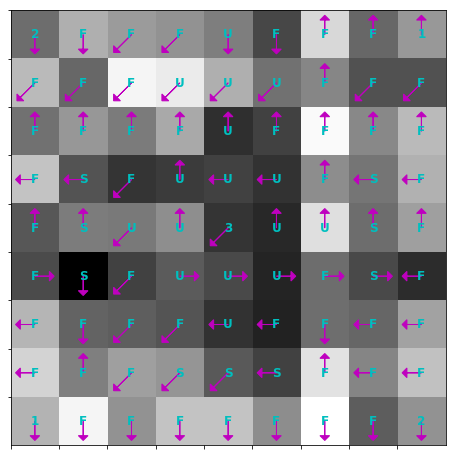

[[0.2        0.2        0.2        0.2        0.2       ]
 [0.2125412  0.2206603  0.18956494 0.16475049 0.21248314]
 [0.22353132 0.24093537 0.1778149  0.13430913 0.22340922]
 [0.23291294 0.2606375  0.16524877 0.10847868 0.23272212]
 [0.24070275 0.27964392 0.15231428 0.08689912 0.24043986]
 [0.21353635 0.19940013 0.19234936 0.17379297 0.22092116]
 [0.21742651 0.2305253  0.17678876 0.14962567 0.22563368]
 [0.22768448 0.25523138 0.16349371 0.12075511 0.23283526]
 [0.23434971 0.27497265 0.15234998 0.09919662 0.23913106]
 [0.2405062  0.29341832 0.14110592 0.07995039 0.24501914]]


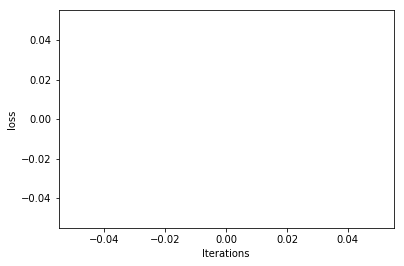

KeyboardInterrupt: 

In [63]:
# I built in a simple update-switcher so I no longer needed to manually stop training and switch update fns

while total_train_time < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    train_log = compute_batch_loss(demo_batch, constraints, step=True, update=update, true_qs=true_qs)        
    if i % 20 == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update=update, true_qs=true_qs)
        for k, v in train_log.items():
            full_train_logs['%s_evals' % k].append(v)
        for k, v in val_log.items():
            if 'val_%s_evals' % k in full_train_logs:
                full_train_logs['val_%s_evals' % k].append(v)
    
    if i % 1000 == 0:
        if i > 5000:
            pu = update
            losses = full_train_logs['val_loss_evals'][(-i//20):]
            update = update_switcher(update, update_progression, losses, slope_threshold=5e-5)
            if pu != update:
                full_train_logs = mode_logs[update]
                print("========= Switching to {} =========".format(update))
                i = 0
            else:
                print([(key,val_log[key]) for key in val_log.keys()])
        else:
            print([(key,val_log[key]) for key in val_log.keys()])
            
    if i % 5000 == 0:
        q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
        plot_values(mdp, q_vals)
        plt.show()
        adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]
        print(softmax(adt_probs))
        
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k][10:])
                plt.show()
    i += 1
    total_train_time +=1

## Frank Wolfe

In [64]:
MAX_ITER = 250
STOP_CRIT = 1e-6
    
def _min_norm_element_from2(v1v1, v1v2, v2v2):
    """
    Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
    d is the distance (objective) optimzed
    v1v1 = <x1,x1>
    v1v2 = <x1,x2>
    v2v2 = <x2,x2>
    """
    if v1v2 >= v1v1:
        # Case: Fig 1, third column
        gamma = 0.999
        cost = v1v1
        return gamma, cost
    if v1v2 >= v2v2:
        # Case: Fig 1, first column
        gamma = 0.001
        cost = v2v2
        return gamma, cost
    # Case: Fig 1, second column
    gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
    cost = v2v2 + gamma*(v1v2 - v2v2)
    return gamma, cost

def _min_norm_2d(vecs, dps):
    """
    Find the minimum norm solution as combination of two points
    This solution is correct if vectors(gradients) lie in 2D
    ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
    """
    dmin = 1e8
    for i in range(len(vecs)):
        for j in range(i+1,len(vecs)):
            if (i,j) not in dps:
                dps[(i, j)] = 0.0
                dps[(i,j)] = np.dot(vecs[i], vecs[j])
                dps[(j, i)] = dps[(i, j)]
            if (i,i) not in dps:
                dps[(i, i)] = 0.0
                dps[(i,i)] = np.dot(vecs[i], vecs[i])
            if (j,j) not in dps:
                dps[(j, j)] = 0.0   
                dps[(j, j)] = np.dot(vecs[j], vecs[j])
            c,d = _min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
            if d < dmin:
                dmin = d
                sol = [(i,j),c,d]
    return sol, dps

def _projection2simplex(y):
    """
    Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
    """
    m = len(y)
    sorted_y = np.flip(np.sort(y), axis=0)
    tmpsum = 0.0
    tmax_f = (np.sum(y) - 1.0)/m
    for i in range(m-1):
        tmpsum+= sorted_y[i]
        tmax = (tmpsum - 1)/ (i+1.0)
        if tmax > sorted_y[i+1]:
            tmax_f = tmax
            break
    return np.maximum(y - tmax_f, np.zeros(y.shape))

def _next_point(cur_val, grad, n):
    proj_grad = grad - ( np.sum(grad) / n )
    tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
    tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])

    skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
    t = 1
    if len(tm1[tm1>1e-7]) > 0:
        t = np.min(tm1[tm1>1e-7])
    if len(tm2[tm2>1e-7]) > 0:
        t = min(t, np.min(tm2[tm2>1e-7]))

    next_point = proj_grad*t + cur_val
    next_point = _projection2simplex(next_point)
    return next_point

def find_min_norm_element(vecs):
    """
    Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
    as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
    It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
    Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
    """
    # Solution lying at the combination of two points
    dps = {}
    init_sol, dps = _min_norm_2d(vecs, dps)

    n=len(vecs)
    sol_vec = np.zeros(n)
    sol_vec[init_sol[0][0]] = init_sol[1]
    sol_vec[init_sol[0][1]] = 1 - init_sol[1]

    if n < 3:
        # This is optimal for n=2, so return the solution
        return sol_vec , init_sol[2]

    iter_count = 0

    grad_mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            grad_mat[i,j] = dps[(i, j)]

    while iter_count < MAX_ITER:
        grad_dir = -1.0*np.dot(grad_mat, sol_vec)
        new_point = _next_point(sol_vec, grad_dir, n)
        # Re-compute the inner products for line search
        v1v1 = 0.0
        v1v2 = 0.0
        v2v2 = 0.0
        for i in range(n):
            for j in range(n):
                v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
        nc, nd = _min_norm_element_from2(v1v1, v1v2, v2v2)
        new_sol_vec = nc*sol_vec + (1-nc)*new_point
        change = new_sol_vec - sol_vec
        if np.sum(np.abs(change)) < STOP_CRIT:
            return sol_vec, nd
        sol_vec = new_sol_vec   
    return sol_vec, nd

def find_min_norm_element_FW(vecs):
    """
    Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
    as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
    It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
    Hence, we find the best 2-task solution, and then run the Frank Wolfe until convergence
    """
    # Solution lying at the combination of two points
    dps = {}
    init_sol, dps = _min_norm_2d(vecs, dps)

    n=len(vecs)
    sol_vec = np.zeros(n)
    sol_vec[init_sol[0][0]] = init_sol[1]
    sol_vec[init_sol[0][1]] = 1 - init_sol[1]

    if n < 3:
        # This is optimal for n=2, so return the solution
        return sol_vec , init_sol[2]

    iter_count = 0

    grad_mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            grad_mat[i,j] = dps[(i, j)]

    while iter_count < MAX_ITER:
        t_iter = np.argmin(np.dot(grad_mat, sol_vec))

        v1v1 = np.dot(sol_vec, np.dot(grad_mat, sol_vec))
        v1v2 = np.dot(sol_vec, grad_mat[:, t_iter])
        v2v2 = grad_mat[t_iter, t_iter]

        nc, nd = _min_norm_element_from2(v1v1, v1v2, v2v2)
        new_sol_vec = nc*sol_vec
        new_sol_vec[t_iter] += 1 - nc

        change = new_sol_vec - sol_vec
        if np.sum(np.abs(change)) < STOP_CRIT:
            return sol_vec, nd
        sol_vec = new_sol_vec
    return sol_vec, nd

def gradient_normalizers(grads, losses, normalization_type):
    gn = {}
    if normalization_type == 'l2':
        for t in grads:
            gn[t] = np.linalg.norm(grads[t])
    elif normalization_type == 'loss':
        for t in grads:
            gn[t] = losses[t]
    elif normalization_type == 'loss+':
        for t in grads:
            gn[t] = losses[t] * np.linalg.norm(grads[t])
    elif normalization_type == 'none':
        for t in grads:
            gn[t] = 1.0
    else:
        print('ERROR: Invalid Normalization Type')
    return gn

In [65]:
num_tasks = 2
# scales = tf.placeholder(tf.float32, [num_tasks], name="scale") 
scales = [tf.placeholder(tf.float32, [1], name="scale{}".format(i)) for i in range(num_tasks)]
clip_norms = [tf.placeholder(tf.float32, [1], name="clipnorm{}".format(i)) for i in range(num_tasks)]
opts = [tf.train.AdamOptimizer(alpha, beta1, beta2) for _ in range(num_tasks)]
loss_fns = np.array([nall_loss, ntll_loss, adt_td_err, adt_td_err_sgq, adt_td_err_sgt])
loss_fns_titles = np.array(['nall', 'ntll', 'tde', 'tde_sq','tde_st', 'loss'])
# loss_configs = [[0],[1],[3],[4]]
loss_configs = [[0,3],[1,4]]

task_losses = [sum(loss_fns[config]) for config in loss_configs]
# # add total loss to the list of losses 
# losses = [[sum(losses[t])] + list(losses[t]) for t in tasks]
loss_titles = [loss_fns_titles[config] for config in loss_configs]


q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=q_scope)
t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=invadt_scope)
all_vars = q_vars + t_vars
all_gvs = [opts[i].compute_gradients(task_losses[i], all_vars) for i in range(num_tasks)]
sep_gvs = [[a for a in zip(*gv_set)] for gv_set in all_gvs]
grads = [[tf.clip_by_norm(sep_gvs[i][0][j], clip_norms[i]) for j in range(len(sep_gvs[i][0]))] for i in range(num_tasks)]
# grads = [gv[0] for gv in sep_gvs]
gvars = [gv[1] for gv in sep_gvs]

# print([v.shape for v in all_vars])


def replace_none_with_zero(grad, var):
    return [tf.zeros_like(var[i]) if grad[i]==None else grad[i] for i in range(len(grad))] 

# print(grads)
# grads = [replace_none_with_zero(grad, all_vars) for grad in grads]
# print(grads)

scaled_grads = [[tf.multiply(g, scales[i]) for g in grads[i]] for i in range(num_tasks)]
updates = [opts[i].apply_gradients(zip(scaled_grads[i],gvars[i])) for i in range(num_tasks)]

gn = "l+"

In [66]:
tf.global_variables_initializer().run(session=sess)

In [67]:
total_train_time = 0

full_train_logs = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
  'sigmas_evals': []
}

[0.00013293 0.99986707]
[('loss', 6.88356), ('nall', 0.78840995), ('tde', 4.13658), ('ntll', 1.9585701)]


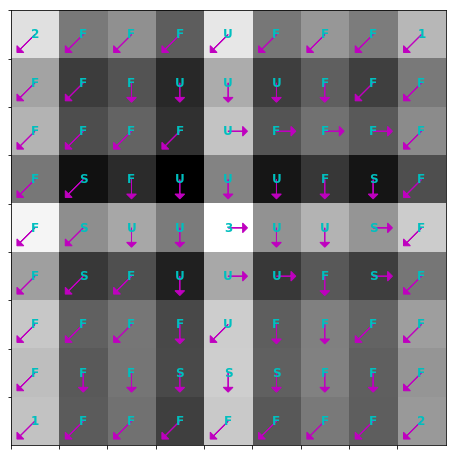

[[0.19999726 0.19996676 0.19994904 0.19993319 0.20015375]
 [0.22738753 0.18693118 0.19116585 0.21557325 0.1789422 ]
 [0.25653335 0.1732106  0.18121831 0.23055962 0.15847808]
 [0.28693515 0.15912187 0.17031643 0.24447493 0.13915163]
 [0.31820282 0.14493245 0.15870528 0.25701934 0.12114006]
 [0.22946113 0.19326517 0.18482591 0.19855507 0.19389275]
 [0.25088444 0.1826823  0.18283382 0.21718669 0.1664127 ]
 [0.27589074 0.1725463  0.16993701 0.23607275 0.14555316]
 [0.30497134 0.15944675 0.15797688 0.24945466 0.12815039]
 [0.3357246  0.14586294 0.14636332 0.26050124 0.11154788]]


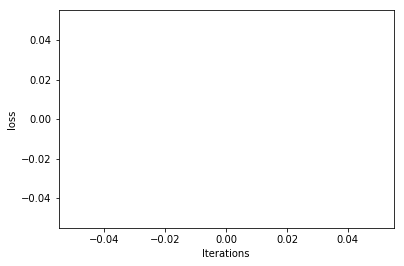

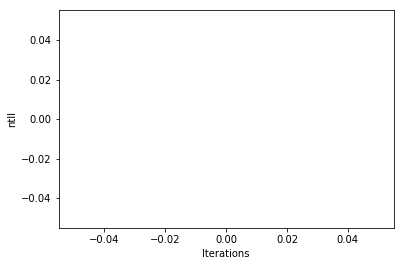

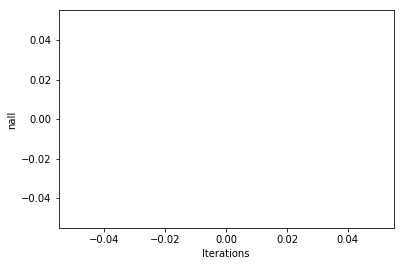

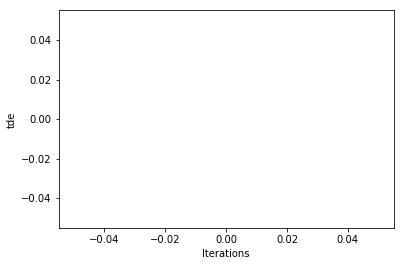

KeyboardInterrupt: 

In [68]:
train_iter = 0
mgda = True
while total_train_time < n_training_iters:
    
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
    
    
    # Scaling the loss functions based on the algorithm choice
    loss_data = {}
    gvs_data = {}
    scale = {}
    mask = None
    masks = {}
    
    # This is MGDA
    grad_arrays = {}
    for t in range(num_tasks):
        # Compute gradients of each loss function wrt parameters
        loss_data[t], gvs_data[t] = sess.run([task_losses[t],all_gvs[t]], feed_dict=feed_dict)
        grad_arrays[t] = np.concatenate([gvs_data[t][i][0].flatten() for i in range(len(gvs_data[t]))])
        #g_loss_data[t] = loss_data[t][1:]
        
    if gn == "l2":
        for i,c in enumerate(clip_norms):
            feed_dict[c] = [1.0]
    elif gn == "l+":
        for i,c in enumerate(clip_norms):
            feed_dict[c] = [loss_data[i]]
        

    # Normalize all gradients
#     gn = gradient_normalizers(grad_arrays, loss_data, "loss+")
#     for t in range(num_tasks):
#         for gr_i in range(len(grad_arrays[t])):
#             grad_arrays[t][gr_i] = grad_arrays[t][gr_i] / gn[t]
            
    



    # Frank-Wolfe iteration to compute scales.
    sol, min_norm = find_min_norm_element(grad_arrays)
#     print(sol)

    # Scaled back-propagation
    for i,s in enumerate(scales):
        feed_dict[s] = [sol[i]]
    for t in range(num_tasks):
        # Inefficient, takes gradients twice when we could just feed the gradients back in
        sess.run(updates, feed_dict=feed_dict)
    
    if total_train_time % 20 == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update="adt")
        for k, v in val_log.items():
            if 'val_%s_evals' % k in full_train_logs:
                full_train_logs['val_%s_evals' % k].append(v)
#         print([(key,val_log[key]) for key in val_log.keys()])


    if total_train_time % 100 == 0:
        print(sol)
        print([(key,val_log[key]) for key in val_log.keys()])

    if train_iter % 1000 == 0:
        q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
        plot_values(mdp, q_vals)
        plt.show()
        adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]
        print(softmax(adt_probs))

        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k][10:])
                plt.show()
    train_iter += 1
    total_train_time +=1

## Testing Training Results

In [ ]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [61]:
# Print learned dynamics
softmax(adt_probs)

array([[0.21851705, 0.21590814, 0.16700909, 0.15032528, 0.24824043],
       [0.12729968, 0.1932118 , 0.1809985 , 0.1537752 , 0.3447148 ],
       [0.09719018, 0.15032631, 0.16841704, 0.1407823 , 0.44328415],
       [0.07598732, 0.11486345, 0.1437389 , 0.11873735, 0.54667306],
       [0.06006168, 0.08776291, 0.11498598, 0.09259684, 0.6445926 ],
       [0.685676  , 0.12618755, 0.02050173, 0.03548481, 0.13214986],
       [0.58982426, 0.12849943, 0.02475517, 0.0442449 , 0.21267632],
       [0.47259033, 0.12424549, 0.0295788 , 0.05008642, 0.32349893],
       [0.3443318 , 0.11211058, 0.03288628, 0.05184946, 0.45882192],
       [0.2359081 , 0.09102884, 0.03271087, 0.04863232, 0.59171987]],
      dtype=float32)

In [62]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

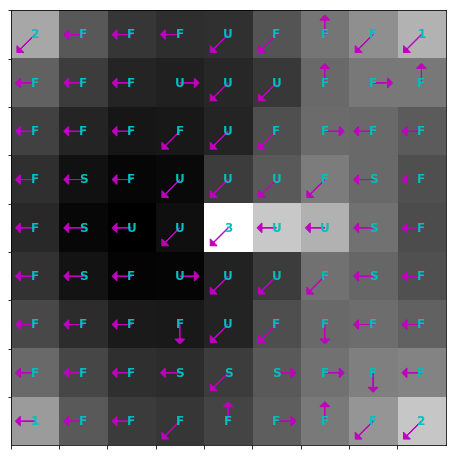

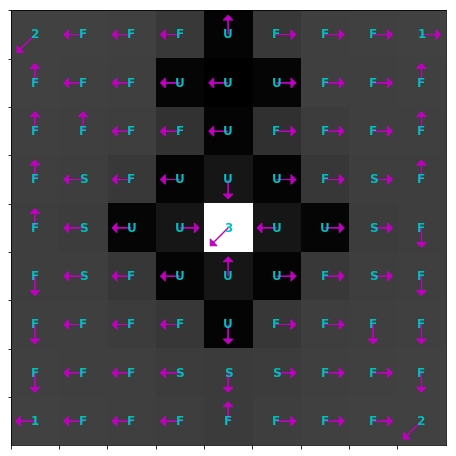

In [63]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

In [64]:
q_vals

array([[153.1029 , 153.18599, 153.40364, 153.63182, 153.85812],
       [146.7244 , 146.31496, 146.26161, 146.27362, 146.29567],
       [143.65764, 143.47844, 143.47469, 143.46315, 143.47095],
       [142.96318, 142.921  , 142.93056, 142.9192 , 142.88196],
       [143.07356, 143.13419, 143.19531, 143.22069, 143.27126],
       [145.81436, 146.19019, 146.33743, 146.40002, 146.40851],
       [148.93004, 149.24854, 149.35287, 149.3818 , 149.37646],
       [151.31067, 151.54335, 151.6623 , 151.7036 , 151.71342],
       [154.02313, 154.28728, 154.53517, 154.76315, 154.85706],
       [147.59251, 147.49393, 147.51799, 147.53645, 147.53816],
       [144.23491, 144.0388 , 144.03215, 144.00816, 144.02446],
       [142.10698, 142.03654, 142.0211 , 142.00862, 141.9806 ],
       [141.8044 , 141.81291, 141.81384, 141.7929 , 141.76076],
       [142.05748, 142.1121 , 142.193  , 142.27017, 142.33632],
       [143.2209 , 143.43413, 143.64703, 143.8227 , 143.91699],
       [147.83318, 148.19604, 148.25937,

In [65]:
Qs

array([[208.44793162, 207.18127902, 207.18127902, 208.44793162,
        210.        ],
       [206.99287621, 202.96944566, 202.29977102, 204.1002877 ,
        204.97294744],
       [204.07436214, 198.44322909, 185.17373676, 199.58882701,
        202.08361852],
       [183.12845022,  36.32702745,  34.95093068, 179.15448334,
        181.34716572],
       [ 16.97620454,  16.79653099,  16.97556524,  16.98153444,
         16.8117191 ],
       [ 35.01525282,  36.16339701, 182.48269324, 179.65517111,
        180.70786631],
       [184.64716479, 197.4379815 , 203.17779759, 200.12479717,
        201.19601961],
       [201.59176201, 201.87644087, 205.87995687, 204.75358624,
        203.87115731],
       [205.32904157, 205.32904157, 208.59211573, 208.59211573,
        207.60626319],
       [204.10032334, 202.30005617, 202.9694813 , 206.99287621,
        204.97294744],
       [204.45205845, 200.28494297, 200.28491827, 204.45205492,
        202.45760476],
       [201.73133557, 178.50494151,  54.197

In [66]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [51]:
# More comprehensive debugging stuff

sa = np.transpose([np.tile(np.arange(mdp.num_states), mdp.num_actions), np.repeat(np.arange(mdp.num_actions), mdp.num_states)])
states, acts = sa[:,0], sa[:,1]

next_states = [[mdp.sd_to_sprime(s,d) for d in range(mdp.nD)] for s in states]
currQs = q_vals[states,acts]
nextQs = q_vals[next_states]

pred_probs = true_tps[acts,:,constraints[4].flatten()]
print(true_tps)
print(softmax(adt_probs).transpose().reshape((5,2,5)))
learned_probs = softmax(adt_probs)[acts,:,constraints[4].flatten()]
print(learned_probs)

test_err, learned_err, targets, learn_convs, test_convs, cspr = sess.run([test_adt_td_err, adt_td_err_sgt, test_adt_target, constraint_v_tp1, test_constraint_v_tp1, constraint_sprimes_reshaped], feed_dict= {constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    test_constraint_q_t_ph: currQs,
                                    test_constraint_q_tp1_ph: nextQs,
                                    test_constraint_adt_pred_probs: pred_probs})
print(test_err, learned_err)
print(learn_convs - test_convs)
print(constraints[3])
print(featurize_states(np.array(next_states).flatten()))
# print(len(next_states) * len(next_states[0]))


NameError: name 'q_vals' is not defined

In [71]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_true_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [72]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_fw_t.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [73]:
# Training data Storage
pkl.dump(mode_logs, open('adt_fw.pkl', 'wb'))

## Comparison Tests (NOT UPDATED)

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)

In [ ]:
mdp.get_possible_sprimes(np.array([[0,0],[0,1]]))

In [ ]:
i = 15
mdp.get_direction_moved(nn_rollouts[0][i][0],nn_rollouts[0][i+1][0])

In [ ]:
nn_rollouts[0][i], nn_rollouts[0][i+1]

In [ ]:
nn_rollouts[0][:30]